In [106]:
using LinearAlgebra
using SparseArrays 
using StructArrays
using StaticArrays
using StaticRanges
using FastGaussQuadrature

using IterativeSolvers
using Preconditioners

using BenchmarkTools
using Profile
using ProfileView

using Plots 

In [107]:
# struct to hold a single mesh element
# all the members of the struct should be concrete type 
struct Element
    p1::Float64    # coordinate left-most node
    p2::Float64    # coordinate right-most node
    e1::Int64      # global index left-most node
    e2::Int64      # global index right-most node
    area::Float64  # area of the element 
  end
  
  # struct to hold entire mesh
  struct Mesh
    nnodes::Int64
    nelements::Int64 
    # specify one-dimensional array of elements as an array of structs. 
    # we worry about using structArray (if as all) later. 
    Elements::Array{Element,1}
    bndNodeIds::Vector{Int64}
    dofPerElement::Int64       
  end 

In [108]:
# function to generate a mesh on the interval 0 <= x <= 1.   
# we limit the type of input to be Int64 
function genMesh(nelements::Int64)::Mesh
    h = 1/nelements 
    nnodes = nelements+1
    dofPerElement = 2 
    x = Vector{Float64}(1:h:2)    
    # what does the undef do here? 
    Elements = Array{Element,1}(undef,nelements)
    for i in 1:nelements
        Elements[i] = Element(x[i],x[i+1],i,i+1,x[i+1]-x[i])
    end
    mesh = Mesh(nnodes,nelements,Elements,[1,nelements+1],dofPerElement)     
    return mesh;
end 

#mesh = genMesh(4)

genMesh (generic function with 1 method)

In [109]:



# generates local stiffness matrix 
function genLocStiffMat(element::Element, densityFunc)
    h     = element.area 
    e1    = element.e1
    e2    = element.e2
    Iloc  = SVector(e1, e1, e2, e2) 
    Jloc  = SVector(e1, e2, e1, e2) 
    
    p1 = element.p1
    p2 = element.p2
    c_avg = (densityFunc(p1) + densityFunc(p2)) / 2

    Aloc  = SVector(c_avg/h, -c_avg/h, -c_avg/h, c_avg/h) 
    return Iloc, Jloc, Aloc
end

# generate global stiffness matrix 
function genStiffMat(mesh::Mesh, densityFunc::C) where C
    
    #..recover number of elements  
    nelements = mesh.nelements
    dofperelem = 4; 
    
    #..preallocate the memory for local matrix contributions 
    Avalues = zeros(Float64,dofperelem*nelements)
    I = zeros(Int64,length(Avalues))
    J = zeros(Int64,length(Avalues))

    for i = 1:nelements #..loop over number of elements..
        element = mesh.Elements[i]
        Iloc, Jloc, Aloc = genLocStiffMat(element, densityFunc) 
        irng = mrange(dofperelem*i-dofperelem + 1,dofperelem*i) 
        I[irng] .= Iloc 
        J[irng] .= Jloc 
        Avalues[irng] .= Aloc         
    end
    
    A = sparse(I,J,Avalues)

    #Dirichlet BC on left node
    #A[mesh.bndNodeIds[1],1] = 1.
    #A[mesh.bndNodeIds[1],2] = 0.
    #Neumann BC on right node - no need to change the matrix
    #print(A)
    return A; 
end
     
#A = genStiffMat(mesh)
#println(A)

genStiffMat (generic function with 1 method)

In [110]:
function calcShapeFuncCoeff(degree)
    numpoints = degree + 1
    points = Vector(LinRange(-1,1,numpoints))
    points
    coeffs = zeros(Float64,numpoints,numpoints)
    x,w = gausslegendre(numpoints)
end
1000
calcShapeFuncCoeff(2)

([-0.7745966692414834, 0.0, 0.7745966692414834], [0.5555555555555556, 0.8888888888888888, 0.5555555555555556])

In [111]:
function genLocVec(element, sourceFct)
    h = element.area 
    Iloc = SVector(element.e1, element.e2)
    floc = (h/2)*SVector(sourceFct(element.p1), sourceFct(element.p2))
    return Iloc, floc
end

function genVector(mesh, sourceFct::F) where F 
    
    #..recover number of elements  
    nelements = mesh.nelements 
    nnodes = mesh.nnodes 
    
    #..initialize global vector  
    f = zeros(Float64,nnodes)

    for i = 1:nelements #..loop over number of elements..
        element = mesh.Elements[i]
        Iloc, floc = genLocVec(element,sourceFct) 
        f[Iloc] .+= floc          
    end

    #Boundary conditions
    #f[mesh.bndNodeIds[1]] = 0.
    #f[mesh.bndNodeIds[2]] = 0.
   
    return f; 
end

#f = genVector(mesh,fsource)
#println(f)
     

genVector (generic function with 1 method)

In [112]:
# generates local mass matrix 
function genLocMassMat(element::Element)
    h     = element.area 
    e1    = element.e1
    e2    = element.e2
    Iloc  = SVector(e1, e1, e2, e2) 
    Jloc  = SVector(e1, e2, e1, e2) 
    Aloc  = SVector(h/3 , h/6, h/6, h/3) 
    return Iloc, Jloc, Aloc
end

# generate global mass matrix 
function genMassMat(mesh::Mesh)
    
    #..recover number of elements  
    nelements = mesh.nelements
    dofperelem = 4
    
    #..preallocate the memory for local matrix contributions 
    Avalues = zeros(Float64,dofperelem*nelements)
    I = zeros(Int64,length(Avalues))
    J = zeros(Int64,length(Avalues))

    for i = 1:nelements #..loop over number of elements..
        element = mesh.Elements[i]
        Iloc, Jloc, Aloc = genLocMassMat(element) 
        irng = mrange(dofperelem*i - dofperelem + 1,dofperelem*i) 
        I[irng] .= Iloc 
        J[irng] .= Jloc 
        Avalues[irng] .= Aloc         
    end
    
    A = sparse(I,J,Avalues)

    #A[mesh.bndNodeIds[1],1] = 0.
    #A[mesh.bndNodeIds[1],2] = 0.
    #A[mesh.bndNodeIds[2],1] = 1.
    #A[mesh.bndNodeIds[2],end] = 0.

    #print(A)
    return A; 
end
#mesh = genMesh(4)
#genMassMat(mesh)

genMassMat (generic function with 1 method)

0.6338674209322386

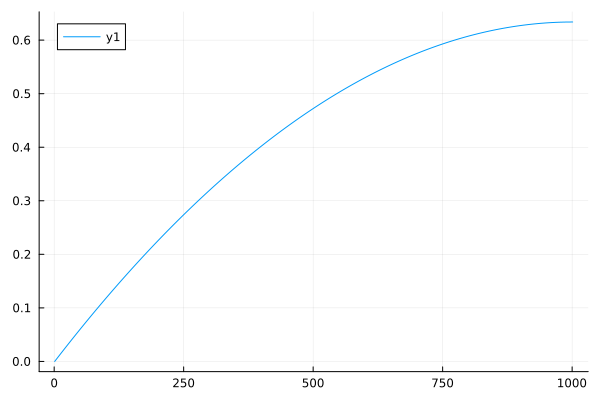

In [115]:
mesh = genMesh(1000)
c(x) = x
S = genStiffMat(mesh,c)
M = genMassMat(mesh)
fsource(x) = x*(x-1)
f = genVector(mesh,fsource)

#println(S)
#println(M)
#println(f)

A = S - M
A[1,1] = 1.
A[1,2] = 0.
#println(A)
#println(det(A))
#println(A[end,end])
#println(A[end,end-1])
f[1] = 0.
#f[end] = 0.

#println(f)

#println(S)

#println(M)

#print(S+M)

u = A \ f


#print(u[end])
#u = S \ f
display(u[end])

#analytical(x) = x - 2 * log(x) - 1
#temp = 1:1/1000:2
#v = zeros(1001)
#for i in 1:1001
#    v[i] = analytical(temp[i])
#end

#v = analytical(temp)
plot(u)



#print(u[end])